# Stochastic Gradient Descent

As in other regression models, we have to deal with the question of how to fit the parameters of the MLP. In the language of neural networks, we speak of **training the model**.

The standard approach to fitting parameters is *maximum-likelihood estimation (MLE)*. For instance, consider a *linear model* $y = wx + \mathcal{N}(0, 1)$ with weight vector $ w = (w_1,\ldots, w_p)^\top$ and i.i.d. training data $\{(x_1, y_1), \ldots, (x_n, y_n)\}$. Writing $y = (y_1, \ldots, y_n)^\top$ and $X = (x_1, \ldots, x_N)^\top$ the log-likelihood $l$ is, given by the quadratic function
$$l(w) =  \sum_{i \le N}\log p_{\mathcal{N}(0,1)}(y_i - w^\top x_i) = -\frac12 \sum_{i} (y_i - w ^\top x_i)^2  + C = -\frac12 \big(y^\top y - 2 y^\top Xw + (Xw)^\top Xw\big) + C$$

In the language of deep learning, the negative log-likelihood $L(w)=-l(w)$ is called **loss function**. 
with gradient
$$\nabla_w L = - X^\top y + X^\top Xw.$$
Solving $\nabla_w l =0$, minimization of the loss function results in $w = (X^\top X)^{-1} X^\top y$. 

In general, the total loss function accumulates additively losses over all samples in the training data:
$$L(w) = \sum_{i \le N} \ell(y_i, f_w(x_i)).$$
The linear model uses the *mean-squared error*: $\ell(y, y') = \tfrac12 (y - y')^2$.

However, if the model is non-linear, then the log-likelihood is typically no longer quadratic in the weights $\theta$ and a closed-form minimization of $L(\theta)$ is typically no longer possible. We therefore have to resort to numerical optimization methods.

## Vanilla Gradient Descent

The most naïve optimization procedure for minimizing the loss function $L$ is **gradient descent**, where we iteratively change the weights by taking steps in the direction of the negative gradient $-\nabla_w L$ of the loss function:
$$w^{(i+1)} = w^{(i)} - \alpha \nabla_w L(w^{(i)}).$$


<img src="images/gradientDesc.png" alt="Drawing" style="width: 500px;"/>
https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent

The [Google Machine Learning Course](./images/learnRate.html) provides a nice illustration of gradient descent.

The step size $\alpha > 0$ is called **learning rate**. In contrast to Newton-Raphson, the learning rate is not computed as a function of the current weights $w^{(i)}$, but rather tuned manually. Whereas choosing the learning rate too large can cause instabilities and failure of convergence, choosing the learning rate too small leads to long convergence times.

### Automatic Gradient Computation

If the MLP $f_w$ consists of many hidden layers, then computing the gradient by hand is painful. A key asset of tensorflow is the automated gradient computation.

In [6]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

ValueError: tf.enable_eager_execution must be called at program startup.

Let's see how this works for the linear model. For simplicity, we only keep the matrix weights and leave the bias aside.

In [7]:
input_dim = 5

class LM(tfe.Network):  
    def __init__(self):    
        super(LM, self).__init__()   
        self.W = tfe.Variable(tf.random_uniform((1,input_dim), -1, 1))
    
    def call(self, input):   
            result = tf.matmul(self.W, input)
            return result

As before, we can now compute the value of the model given the initial parameters. To make it more comparable to a later setting, we increase the sample size to 1,000,000. We also make an assumption of a true model and generate corresponding response variables.

In [5]:
tf.set_random_seed(42)
input_size = int(1e6)

model = LM()
x = tf.random_uniform((input_dim, input_size), -1, 1)
y_pred = model(x)

w_true = [[1., 2., 3., 4., 5.]]
y = tf.matmul(w_true, x) + tf.random_uniform((1, input_size), -.1, .1)

As the loss function, we use mean-squared error.

In [5]:
def loss_function(model, x, y):  
    y_ = model(x)
    return tf.losses.mean_squared_error(y, y_) 

In the beginning, the weight matrix is far away from its true value

In [6]:
model.W

<tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=
array([[ 0.3291242 , -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
      dtype=float32)>

With tensorflow, we can retrieve both the gradient and the actual values of the weights.

In [7]:
tfe.implicit_gradients(loss_function)(model, x, y)

[(<tf.Tensor: id=113, shape=(1, 5), dtype=float32, numpy=
  array([[-0.44741115, -1.4015851 , -2.1849227 , -2.7139482 , -3.949926  ]],
        dtype=float32)>,
  <tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=
  array([[ 0.3291242 , -0.11798644, -0.294235  , -0.07103491, -0.9326792 ]],
        dtype=float32)>)]

After taking 500 gradient steps the weights are much closer to the true value.

In [32]:
%%time
for i in range(500):
    grad = tfe.implicit_gradients(loss_function)(model, x, y)[0][0]
    model.W.assign_sub(.01 * grad)
print(model.W)

<tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=
array([[0.9762546, 1.9234493, 2.881829 , 3.8563163, 4.7897825]],
      dtype=float32)>
CPU times: user 36.9 s, sys: 9.91 s, total: 46.8 s
Wall time: 19.1 s


## Initialization

Note that using backpropagation as optimization method has important consequences on also on the choice of initial weights. Indeed, if all weights and biases are initialized as 0, then gradients tend to vanish or degenerate and no learning is possible.

 Hence, we need to rely on a random initialization. However, if the scale of the random initial weights is chosen too large, then gradient descent results into exploding gradients. What has been found to work well in practice is the [Xavier-Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), where weights are initialized in the interval $[-\sqrt{6}/\sqrt{d_\mathsf{in}+d_\mathsf{out}},\sqrt{6}/\sqrt{d_\mathsf{in}+d_\mathsf{out}}]$, where $d_\mathsf{in}$ and $d_\mathsf{out}$ denote the input and output dimensions of the considered layer.

$\def\ms{\mathsf}$
Loosely speaking, in the forward pass the variance of the randomness at a neuron in the output is $d_\mathsf{out}\mathsf{Var}(w_{ij})$. Similarly, in the backward pass, we would obtain a restriction $d_\mathsf{in}\mathsf{Var}(w_{ij})$ should be constant. A compromise between the two conditions leads to the asserted initialization proposal.

## Homework: Iris classification

Define a single-layer MLP for the classification problem in the iris dataset and optimize it via gradient descent.

Optimize over the *cross-entropy loss*. If $(p_1, p_2, p_3)$ are the predicted class probabilities and $y$ is the true outcome, then this loss is given by 
$$\ell(y, \{p_i\}_{i \le 3}) = -\sum_{i=1}^3 \mathbb{1}\{y = i\} \log p_i.$$

Assuming the values of the final layer correspond to the class probabilities, optimizing cross-entropy is equivalent to maximum-likelihood estimation.

## Stochastic Gradient Descent

We see that if there is a lot of training data, then computing gradients iteratively can be prohibitively time-consuming. The idea of **stochastic gradient descent (SGD)** is to select only a subset $J$  of all training indices. The associated sub-sample is called **mini-batch**. Instead of computing the loss based on all training data, only the data in the mini-batch is used. That is, 
$$L_{\mathsf{SGD}}(w) = \sum_{i \in J} \ell(y_i, f_w(x_i)).$$


Let's see how this works out for the linear model considered above.

In [40]:
%%time
import numpy.random as random
batch_size = 128
tf.set_random_seed(42)
model = LM()

for i in range(500):
    xb = tf.slice(x, [0, i * batch_size], [input_dim, batch_size])
    yb = tf.slice(y, [0, i * batch_size], [1, batch_size])
    
    grad = tfe.implicit_gradients(loss_function)(model, xb, yb)[0][0]
    model.W.assign_sub(.01 * grad)
print(model.W)

<tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=
array([[0.9715018, 1.9286776, 2.8780506, 3.8595467, 4.7856936]],
      dtype=float32)>
CPU times: user 746 ms, sys: 0 ns, total: 746 ms
Wall time: 748 ms


Hence, we arrive almost at the same accuracy in a fraction of the time. Moreover, the randomness injected by choosing only to optimize over mini-batches helps to fight overfitting and leads to solutions that generalize better.

### Under the Hood: Backpropagation

We see that `tensorflow` does a great job computing gradients for us. But what actually happens, when calling `implicit_gradients`? [Recall](./mlp.ipynb) that an MLP can be written in the form
$$f(x) = a_L(W_L \cdot a_{L-1}(W_{L-1}\cdots (W_2 \cdot a_1(W_1 \cdot x + b_1) + b_2)\cdots) + b_{L})$$
with weights $W_i \in \mathbb{R}^{\ell_i \times \ell_{i-1}}$, biases $b_i \in \mathbb{R}^{\ell_i}$ and activation functions $a_i:\mathbb{R}^{\ell_i} \to \mathbb{R}^{\ell_i}$.

We can write $f$ more succinctly as a composition of functions 
$$f(x) = g^{(L)}_{W_L, b_L}(\cdots (g^{(2)}_{W_2, b_2}(g^{(1)}_{W_1, b_1}(x)))),$$
where $g^{(i)}_{W_i, b_i}(z) = a_i(W_i z + b_i)$. Since $f$ is a composition of functions, the gradients can now be computes by invoking the chain rule. This technique of automatic differentiation is called **backpropagation** and goes back to a [seminal paper](https://www.nature.com/articles/323533a0) by David E. Rumelhart, Geoffrey E. Hinton & Ronald J. Williams published in 1986.

The [Google Machine Learning Crashcourse](./images/backProp.html) provides a beautiful illustration for backpropagation.

<img src="images/backProp.png" alt="Drawing" style="width: 400px;"/>
https://google-developers.appspot.com/machine-learning/crash-course/backprop-scroll/

We explain the general idea in the case where $L = 2$ without biases: $b_2 = b_1 = 0$. Since $a_2$ is typically a loss function, we assume the last layer to be one-dimensional, i.e., $\ell_2=1$. To simplify notation, we write $\ell = \ell_1$ and $m = \ell_0$. Hence, $W_2 = (w_{2;1}, w_{2;2}, \ldots, w_{2;\ell})$.

Hence, writing $\big(g^{(1)}_{W_1}(x)\big)_k$ for the $k$-th component of $g^{(1)}_{W_1}(x)$, the chain rule gives
$$\begin{align*}
\frac{\partial}{\partial w_{2;j}}a_2(W_2 g^{(1)}_{W_1}(x))&= \frac{\partial}{\partial w_{2;j}}a_2\Big(\sum_k w_{2;k} 
\big(g^{(1)}_{W_1}(x)\big)_k\Big)\\
&= a_2'\Big(\sum_k w_{2;k} 
\big(g^{(1)}_{W_1}(x)\big)_k\Big) \frac{\partial}{\partial w_{2;j}}\sum_k w_{2;k} 
\big(g^{(1)}_{W_1}(x)\big)_k\\
&= a_2'\Big(W_2 g^{(1)}_{W_1}(x)\Big)\big(g^{(1)}_{W_1}(x)\big)_j
\end{align*}$$
Hence, 
$$\nabla_{W_2} f(x) =  a_2'(W_2 g^{(1)}_{W_1}(x))g^{(1)}_{W_1}(x).$$

Note that the expressions $W_2 g^{(1)}_{W_1}(x)$ and $g^{(1)}_{W_1}(x)$ were already evaluated when computing $f(x) = a_2(W_2 a_1(W_1x))$

The computation of the partial derivatives is similar with the exception that we now also have to apply the chain rule for $g_{W_1}^{(1)}$:
$$\frac{\partial}{\partial w_{1;i,j}}a_2(W_2 g^{(1)}_{W_1}(x)) = a_2'\Big(W_2 g^{(1)}_{W_1}(x)\Big) \frac{\partial}{\partial w_{1;i,j}}\Big(W_2 g^{(1)}_{W_1}(x)\Big)= a_2'\Big(W_2 g^{(1)}_{W_1}(x)\Big) W_2 \frac{\partial}{\partial w_{1;i,j}}g^{(1)}_{W_1}(x)$$

Note that we again have already computed $a_2'\Big(W_2 g^{(1)}_{W_1}(x)\Big)$ when computing gradients with respect to $W_2$. Hence, we can proceed recursively and it only remains to compute the gradients for $g^{(1)}_{W_1}$.

The above calculations already provide a very strong hint that when computing $f(x)$ and its gradients $f(x)$ many intermediate should be stored and re-used at a later stage. More precisely, the training via SGD decomposes into a **forward pass** and a **backward pass**.

#### Forward Pass

First, we compute $f(x)= g^{(L)}_{W_L}(\cdots (g^{(2)}_{W_2}(g^{(1)}_{W_1}(x))))$ recursively:

* compute $g^{(1)}_{W_1}(x)$ and save the value as $h^{(1)}$
* compute $g^{(2)}_{W_2}(h^{(1)})$ and save the value as $h^{(2)}$
* continue recursively until arriving at $f(x) = g^{(L)}_{W_L}(h^{(L-1)})$

This is called the **forward phase** since we start with the computation of the innermost expression and make our way forward until we arrive at the outermost position.

#### Backward Phase

In the backward phase, we compute the gradients of $\nabla_W f(x)$ via the chain rule. Here, we start by computing the outermost expressions and make our way to the innermost expression. 
* To compute the gradients $\nabla_{W_L} f(x)$ with respect to the outermost weights, we proceed as above to see that $\nabla_{W_L} f(x) = (\nabla_{W_L} g^{(L)}_{W_L})(h^{(L-1)}) \cdot h^{(L-1)}$. 
* To compute the gradients $\nabla_{W_{L-1}} f(x)$ with respect to $W_{L-1}$, we proceed as above to see that $\nabla_{W_{L-1}} f(x) = (\nabla g^{(L)}_{W_L})(h^{(L-1)}) \cdot (\nabla_{W_{L-1}} g^{(L-1)}_{W_{L-1}})(h^{(L-2)})$. We save the expression $(\nabla g^{(L)}_{W_L})(h^{(L-1)})$
* To compute the gradients $\nabla_{W_{L-2}} f(x)$ with respect to $W_{L-2}$, we proceed as above to see that $\nabla_{W_{L-2}} f(x) = (\nabla g^{(L)}_{W_L})(h^{(L-2)}) \cdot (\nabla g^{(L-1)}_{W_{L-1}}(h^{(L-2)}) (\nabla_{W_{L-1}} g^{(L-2)}_{W_{L-2}})(h^{(L-3)})$. We can reuse the expression $(\nabla g^{(L)}_{W_L})(h^{(L-1)})$ from the previous step and  save additionally the expression $\nabla g^{(L-1)}_{W_{L-1}}(h^{(L-2)})$

You already see that the computations can get rather involved. All the details are presented in  [Chapter 6.5 of the monograph on Deep Learning](http://www.deeplearningbook.org/) by  Aaron Courville, Ian J. Goodfellow, and Yoshua Bengio.

The upshot of the backpropagation algorithm is that one training step in the backpropagation algorithm takes essentially one forward pass and one backward pass through the network. Hence, it takes roughly twice as long as a simple evaluation. However, as we will see in the practical examples, many passes over the data might be needed until the weights have converged.

## Vanishing & Exploding Gradients

Now, that we have walked through SGD, we can understand better why it was not possible to build deep nets in the 1980s and 1990s.

The chain rule causes many multiplications as a gradient travels through the multiple layers. If the multiplications are not precisely fine-tuned, then the gradients become numerically unstable. To understand what happens when plugging in numerically unstable values into a sigmoid function, let's plot it once more. 

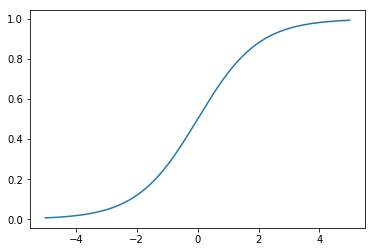

In [2]:
import matplotlib.pyplot as plt  
import numpy as np  
%matplotlib inline

t = np.arange(-5, 5, 0.01)  
s = 1/(1 + np.exp(-t))
plt.plot(t, s)  
plt.show()  

Inserting large values into the sigmoid throws into a region where the function is almost flat, so that the gradients become essentially 0. In particular, any information collected by the backpropagation information will be lost after this point. 

One embarassingly simple solution to this problem is to replace the sigmoid with the activation function $\max(0, x)$, also known as **Rectified Linear Unit (ReLU)**.

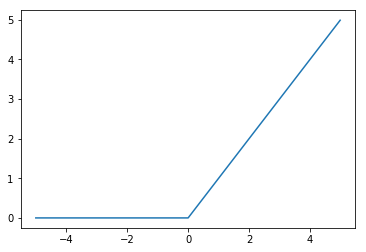

In [14]:
import matplotlib.pyplot as plt  
import numpy as np  
%matplotlib inline

t = np.arange(-5, 5, 0.01)  
s = np.maximum(t, np.zeros(len(t)))
plt.plot(t, s)  
plt.show()  

The advantage of this function is that if we insert large positive values, the gradient never vanishes but remains constant at 1. This simple trick helps a lot for being able to send gradients through many layers without them getting killed.

## Homework: Backpropagation - Theory

Finish the computation of $\nabla_{W_1}f(x)$.

Why does the gradient computation involve backpropagation? Couldn't we just as well compute in a feed-forward manner?

Would it not be better to choose a linear activation function $a(x) = c \cdot x$ instead of ReLU? Here, there is never a problem of a vanishing gradient.

## Homework: Backpropagation - Implementation

Implement the backpropagation with $L = 2$.